# Chapter 05 - Resampling Methods

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm.notebook import tqdm_notebook

import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

colors= [c['color'] for c in plt.rcParams['axes.prop_cycle']]

## Figure 5.2

Creating 10 random train/val splits of the `Auto` data set in order to estimate the test error that results from predicting `mpg` using polynomial functions of `horsepower`.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def train_eval(model, X_train, y_train, X_val, y_val):
    """
    Train a model and return the MSE on 
    the validation set
    """
    model.fit(X_train, y_train)
    
    val_preds = model.predict(X_val)
    
    return mean_squared_error(y_val, val_preds)
    
    

auto = pd.read_csv('../data/auto.csv')

lr = LinearRegression()

X = auto[['horsepower']]
y = auto['mpg']

scores = {}
for degree in range(1, 11):
    
    if degree > 1:
        # Add the nth degree polynomial
        X[f'hp_{degree}'] = X['horsepower']**degree
        
    # Use the same random state for each split
    # X will have new features as degree increases
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)
        
    val_score = train_eval(lr, X_train, y_train, X_val, y_val)

    scores[degree] = val_score

In [5]:
lr = LinearRegression()

X = auto[['horsepower']]
y = auto['mpg']


# Now repeat but add 10 random train/test splits
scores_cv = pd.DataFrame(index=pd.Series(range(1, 11),name='degree'), columns=range(10))
for degree in range(1, 11):
    
    if degree > 1:
        # Add the nth degree polynomial
        X[f'hp_{degree}'] = X['horsepower']**degree
        
    for n in range(10):
        
        # Use the same random state for each split
        # X will have new features as degree increases
        X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=n)

        val_score = train_eval(lr, X_train, y_train, X_val, y_val)

        scores_cv.loc[degree,n] = val_score

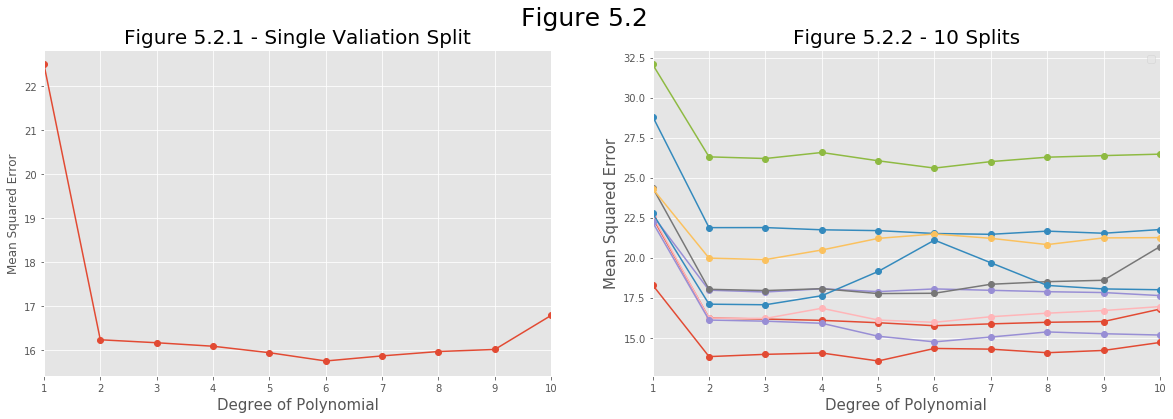

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

fig.suptitle('Figure 5.2', fontsize=25)

# Left hand side
scores = pd.Series(scores)
scores.plot(marker='o', ax=axes[0])
axes[0].set_xlabel('Degree of Polynomial', fontsize=15)
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('Figure 5.2.1 - Single Valiation Split', fontsize=20)


scores_cv.plot(marker='o', ax=axes[1])
axes[1].set_xlabel('Degree of Polynomial', fontsize=15)
axes[1].set_ylabel('Mean Squared Error', fontsize=15)
axes[1].set_title('Figure 5.2.2 - 10 Splits', fontsize=20);
axes[1].legend([])

## Figure 5.4 

Leave One Out Validation vs 10-Fold Cross Validation

In [7]:
from sklearn.model_selection import cross_val_score, KFold

lr = LinearRegression()

X = auto[['horsepower']]
y = auto['mpg']

# Number of observations
N = X.shape[0]

# Leave One Out Validatoin
scores_loo = pd.DataFrame(index=pd.Series(range(1, 11),name='degree'), columns=range(N))
scores_cv = pd.DataFrame(pd.Series(range(1, 11),name='degree'), columns=range(9))

for degree in range(1, 11):
    print('Degree: ',degree)
    
    if degree > 1:
        # Add the nth degree polynomial
        X[f'hp_{degree}'] = X['horsepower']**degree
        
        
    for n in tqdm_notebook(range(N),desc='LOO'):

        X_train, y_train = X.drop(n), y.drop(n)
        
        X_val, y_val = X.loc[n], y.loc[n]
        
        X_val = X_val.values.reshape(1,-1)
        y_val = y_val.reshape(1, -1)
    
        val_score = train_eval(lr, X_train, y_train, X_val, y_val)
        
        scores_loo.loc[degree, n] = val_score
        
    
    # Do 9 CV-splits
    for k in tqdm_notebook(range(9), desc='K-Fold'):
        
        # To get randomness between CV runs, we set shuffle=true and have a different
        # random seed each run
        cv = KFold(n_splits=10, shuffle=True, random_state=k*np.random.randint(1,100))
    
        cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error')
        
        val_score = -1*np.mean(cv_scores)

        scores_cv.loc[degree, k] = val_score
        


Degree:  1



Degree:  2



Degree:  3



Degree:  4



Degree:  5



Degree:  6



Degree:  7



Degree:  8



Degree:  9



Degree:  10


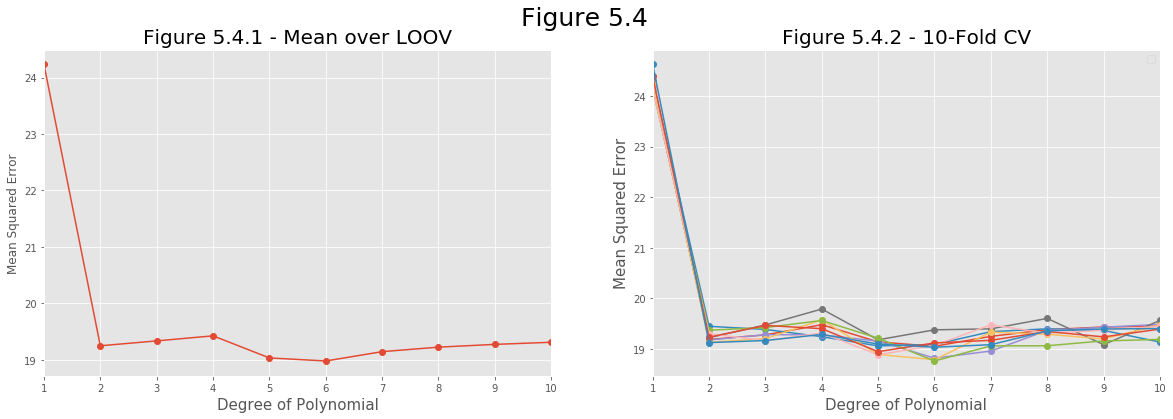

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(20,6))

fig.suptitle('Figure 5.4', fontsize=25)

# Left hand side
loo_scores = scores_loo.mean(axis=1)
loo_scores.plot(marker='o', ax=axes[0])
axes[0].set_xlabel('Degree of Polynomial', fontsize=15)
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('Figure 5.4.1 - Mean over LOOV', fontsize=20)


scores_cv.plot(marker='o', ax=axes[1])
axes[1].set_xlabel('Degree of Polynomial', fontsize=15)
axes[1].set_ylabel('Mean Squared Error', fontsize=15)
axes[1].set_title('Figure 5.4.2 - 10-Fold CV', fontsize=20);
axes[1].legend([]);

## Bias - Variance Trade off in Cross Validation

* Bias _decreases_ as K increases
* Variance _increases_ as K increases

**Why?** 

The higher K is, the more similar the training sets are between folds. For example, LOOV has almost exactly the same training data for each fold. This results in highly correlated predictions between folds - and apparantly (I didnt know this) the variance of correlated samples is higher than that of uncorrelated samples.


**Practical Use**

Cross validation can be used for two main purposes:

1. Model evaluation
2. Model selection

During model evaluation, the goal is to determine how well a learning algorithm is expected to beform on a new dataset. In this case, the actual error metric estimate is important. 

But during model selection, we are less interested in the _actual value_ of the error metric, and more interested in the _position_ of the error metric. For example, when choosing the flexibility we are interested in which value achieves a minimum CV estimate of the error metric. Not so much in what that error estimate is. 

Considering the bias variance trade-off, the rule of thumb is:
* During model evaluation, use a higher value of K (lower bias) --> 10 is typical
* During model selection, settle for lower value of K (faster computation) --> 5 is typical, but can be as low as 2 if data is large enough.

# Bootstrapping

Bootstrapping is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method.


**How?**

Given some dataset $X$, we can create a bootstrapped sample dataset by taking $B$ random samples of size $N$ _with replacement_ from that dataset. This will create $X_1^N, X_2^N, \ldots, X_B^N$.

We can then compute any summary statistic, such as a simple mean, or train a model to produce a prediction, on each of the $B$ datasets. These _bootstrap estimates_ can then be used to calculate a confidence interval around the estimate of interest. 

In [15]:
auto = pd.read_csv('../data/auto.csv')
print(auto.shape)
auto.head()

(392, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [16]:
auto.year.unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

### Sample vs Population

In the real world, we almost never have access to an entire population's data. For example, if you want to know the average weight of teenagers in a district, it's impractical to gather the actual weights of each teenager in that district. But if it were possible, that dataset will be referred to as the _population_.

Rather, we would usually take a _sample_ from true population and use that sample to calculate some statistics that represent the population. Bootstrapping comes in handy when we want to quantify how confident we are that our samples statistic contain the true (population) statistic. 

### Example

In the `auto` example, we have data about cars from 1970 to 1982. We will assume this to be our population - ie that this represents all cars during those years. 

To illustrate the premise of bootstrapping, we will take 100 random samples from this dataset - this will represent the _sample_ and compute the mean for the `weight` and `acceleration` for both the population and sample datasets. 

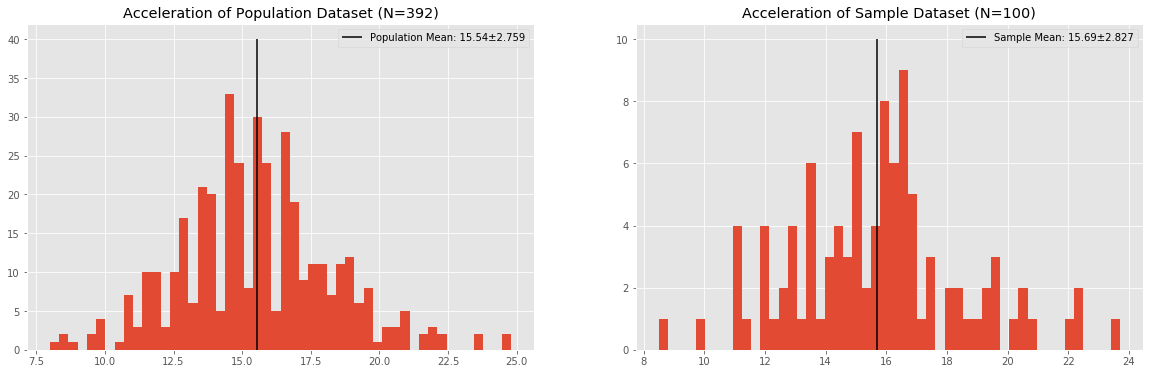

In [37]:
sample = auto.sample(100)

fig, axes = plt.subplots(ncols=2, figsize=(20,6))

# Population
p = auto.acceleration
s = sample.acceleration

axes[0].hist(p, bins=50)
axes[0].set_title('Acceleration of Population Dataset (N=392)')
axes[0].vlines([p.mean()], 0, 40, label='Population Mean: {:.2f}±{:.3f}'.format(p.mean(), p.std()))
axes[0].legend()

axes[1].hist(s, bins=50)
axes[1].set_title('Acceleration of Sample Dataset (N=100)')
axes[1].vlines([s.mean()], 0, 10, label='Sample Mean: {:.2f}±{:.3f}'.format(s.mean(), s.std()))
axes[1].legend()

plt.show()

As we can see, the sample closely resembles the population. The population and sample means are approximately `0.2` (or 0.1 standard deviation) from each other. This might be different for each run, but should not be too far off. 

But lets consider that we did not know that the population mean is, and we did not know how far off our sample mean is from it. We would want to know **how confident can we be about the sample mean**. 

To answer that, we can use bootstrapping!

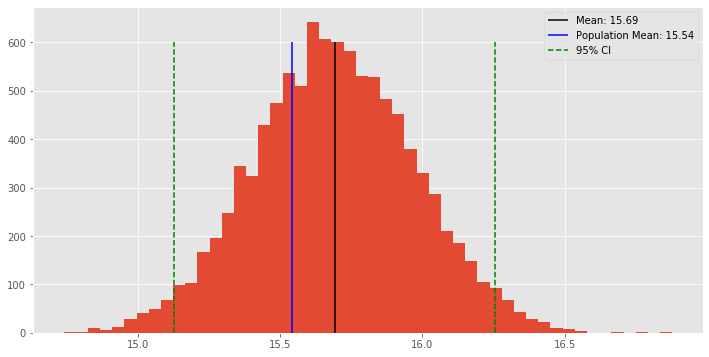

In [65]:
# Its usually a smart idea to take as many samples with replacement as there is in the sample dataset
# If it's too computationally expensive you can lower this value, but it will widen the confidence intervals
N = 100 
B = 10000

bootstrap_means = []
for b in tqdm_notebook(range(B)):
    # Take N random samples with replacement
    bootstrap_sample = np.random.choice(s,size=N, replace=True)
    
    # Calculate the mean
    bootstrap_means.append(np.mean(bootstrap_sample))
    

    
# Plot the distribution of bootstrap means
bootstrap_means = np.array(bootstrap_means)

plt.figure(figsize=(12,6))
plt.hist(bootstrap_means, bins=50);
plt.vlines([bootstrap_means.mean()], 0, 600, label='Mean: {:.2f}'.format(bootstrap_means.mean()))
plt.vlines([p.mean()], 0, 600, 'b', label='Population Mean: {:.2f}'.format(p.mean()))
plt.vlines([bootstrap_means.mean()-2*bootstrap_means.std(), bootstrap_means.mean()+2*bootstrap_means.std()], 
           0, 600 ,'g','--', label='95% CI')
plt.legend()

In [66]:
print('CI lower and upper bounds:', bootstrap_means.mean()-2*bootstrap_means.std(), bootstrap_means.mean()+2*bootstrap_means.std())

CI lower and upper bounds: 15.129318431374386 16.253880368625616


The figure above shows the distribution of 1000 means taken from 50 "bootstrap" samples of the original sample (100 cars) that we took from the population. 

According to the central limit theorem, bootstrapped means will approximate a normal distribution. Which is why this distribution is so similar to a normal distribution - it approximates it!. 

Knowing that the distribution of bootstrapped means (or any statistic for that matter) is approximately normally distributed, we can get to draw confidence intervals based on the standard deviation (Z-scores). 

We show above that we are **95% confident that the population mean will fall between 15.13 and 16.25**. 